# SETUP

In [1]:
# Change this variable to use GPU
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.models import load_model
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1757219506.782459 3566694 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757219506.788549 3566694 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757219506.804045 3566694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757219506.804059 3566694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757219506.804061 3566694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757219506.804063 3566694 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration


In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx', 'target_start_date': '2022-01-01', 'target_end_date': '2022-12-31'}, 'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv', 'target_start_date': '2021-01-01', 'target_end_date': '2021-12-31'}, 'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv', 'target_start_date': '2021-01-01', 'target_end_date': '2022-12-31', 'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv', 'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv', 'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv', 'merged_data_dir_all_locations': '/le_thanh_van_118/workspace/

# MPAIR DATA

## Load dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [4]:
df_mpair_raw = pd.read_csv(conf["dataset"]["mpair"]["merged_data_dir"])
df_mpair_raw

,i,j,lat,lon,time,pm25_3km,tmp,rh,hpbl,wspd,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
0,16,17,10.789976,106.689516,2021-01-01,38.528156,25.759054,61.073494,520.164246,3.809916,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,201,17.250000
1,16,17,10.789976,106.689516,2021-01-02,57.013439,25.378061,61.142441,524.404724,2.527972,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2,16,17,10.789976,106.689516,2021-01-03,57.202629,26.691256,62.528309,467.049805,1.928542,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,201,28.291667
3,16,17,10.789976,106.689516,2021-01-04,61.890816,27.549019,62.431583,600.658997,1.653818,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,201,28.791667
4,16,17,10.789976,106.689516,2021-01-05,70.329758,27.360172,63.041634,654.842773,2.941231,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,16,16,10.789976,106.666630,2022-12-27,34.151028,24.213715,69.134701,463.417114,2.020892,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,-9999.000000,216,39.659816
4011,16,16,10.789976,106.666630,2022-12-28,29.592785,25.896009,62.308920,647.989014,2.376687,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,-9999.000000,216,44.679352
4012,16,16,10.789976,106.666630,2022-12-29,27.141323,25.894251,63.947048,813.575928,2.991689,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708
4013,16,16,10.789976,106.666630,2022-12-30,19.889748,25.035917,61.037365,668.597046,4.194347,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,-9999.000000,216,33.091428


In [5]:
df_mpair_raw.columns

Index(['i', 'j', 'lat', 'lon', 'time', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd',
       'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland',
       'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod',
       'station', 'pm25'],
      dtype='object')

In [10]:
df_mpair_stat = df_mpair_raw.describe()
df_mpair_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_mpair_stat.csv')
df_mpair_stat

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
count,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,...,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,3650.000000,4008.000000,4015.000000,2573.000000
mean,15.727273,16.909091,10.796108,106.687436,20.016764,27.667259,72.819179,584.621745,2.904415,38141.941818,...,5386.889894,824465.661811,5131.602178,25684.641853,95163.271182,44147.502135,1989.178289,-inf,211.636364,21.590449
std,1.482867,2.065315,0.033343,0.047268,11.011492,1.324721,7.891644,150.714332,0.897992,13442.966309,...,6413.901989,122803.558899,7644.041379,42731.715224,62381.250748,42051.804366,285.627862,NaN,5.227726,9.277763
min,12.000000,14.000000,10.745004,106.620857,5.310157,22.685747,48.843470,75.282761,0.943553,7734.378000,...,1056.256477,489934.909940,9.037443,1221.246398,48393.446780,492.146554,1686.406661,-inf,201.000000,5.154861
25%,15.000000,16.000000,10.767490,106.666630,12.387140,26.926373,67.500707,494.686920,2.298321,29013.390000,...,1895.437302,750386.334790,28.761909,2906.313289,57668.133163,12262.365566,1830.941629,-9999.000000,211.000000,14.833661
50%,16.000000,17.000000,10.789976,106.689516,17.113537,27.776381,73.237984,586.126282,2.747607,44587.590000,...,2272.289336,878404.088663,229.889184,7179.267694,86858.898791,32195.290892,1876.516122,-9999.000000,214.000000,19.491667
75%,17.000000,18.000000,10.812461,106.712403,23.965211,28.580388,78.728626,681.663361,3.310916,47421.883000,...,5573.831706,911973.882028,6083.319648,17783.771810,95404.824438,46929.703983,2042.834978,0.157691,215.000000,26.691525
max,18.000000,22.000000,10.879919,106.803950,87.359993,33.235374,93.107094,1367.739014,6.165152,51071.230000,...,21079.583330,929982.248561,20717.659283,151361.367404,282947.325347,127492.687793,2580.669322,3.131525,216.000000,87.416667


In [11]:
df_mpair_raw.isnull().sum()

i                       0
j                       0
lat                     0
lon                     0
time                    0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km    2555
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                  365
aod                     7
station                 0
pm25                 1442
dtype: int64

### Handle metadata

In [12]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Convert the -9999 to nan
df_mpair_raw[df_mpair_raw <= -9999] = np.nan

# Drop columns
# These columns are not available in the model trained by AOD data
#df_mpair_raw.drop(columns=["aimodel", "pres2m", "road_len_1km"], inplace=True)

# Print
df_mpair_raw

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


### Define label, static features and dynamic features

In [13]:
mpair_label = ["pm25"]
mpair_index = ["time"]
mpair_stat_feats = ['lat', 'lon', 'pop', 'pm25_3km', 'road_den_1km', 'prim_road_len_1km', \
                    'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', \
                    'water', 'ndvi']
mpair_dyn_feats = list(set(df_mpair_raw.columns) - set(mpair_stat_feats) - set(["i", "j"]) - set(mpair_label) - set(mpair_index))
print(f'mpair_label = {mpair_label}\nmpair_stat_feats = {mpair_stat_feats}\nmpair_dyn_feats = {mpair_dyn_feats}')

mpair_label = ['pm25']
mpair_stat_feats = ['lat', 'lon', 'pop', 'pm25_3km', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_dyn_feats = ['wspd', 'station', 'tmp', 'rh', 'aod', 'hpbl']


In [14]:
mpair_all_stations = df_mpair_raw["station"].unique()
mpair_all_stations

array([201, 211, 212, 213, 214, 215, 216])

### Handle invalid data

Value less than or equal to -9999 are invalid
* -340282300000000032739046872047385837568.0
* -1797693000000000049799130911535464311773856769...
* -9999
* ...

It means those values are not collected

Convert them to NaN to fill later

In [15]:
null_stats = df_mpair_raw.isnull().sum()
print(f"Null values:\n{null_stats}")

columns_to_fill = list(null_stats[null_stats > 0].keys())
print(f"\nColumns to fill:\n{columns_to_fill}")

Null values:
i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km    2555
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                  365
aod                  2965
station                 0
pm25                 1442
dtype: int64

Columns to fill:
['prim_road_len_1km', 'ndvi', 'aod', 'pm25']


#### Fill static features

In [16]:
# Fill the static features with zero
stat_feats_to_fill = set(mpair_stat_feats) & set(columns_to_fill)
for feat in stat_feats_to_fill:
    df_mpair_raw[feat].fillna(value=0, inplace=True)

# Check null
print(df_mpair_raw.isnull().sum())

# Printout
df_mpair_raw

i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2965
station                 0
pm25                 1442
dtype: int64


/tmp/ipykernel_3566694/4120575362.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mpair_raw[feat].fillna(value=0, inplace=True)


,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


#### Fill dynamic features

In [17]:
# Fill the dynamic features with mean value for each station
dyn_feats_to_fill = set(mpair_dyn_feats) & set(columns_to_fill)
all_stations_data = []
for station in mpair_all_stations:
    df_mpair_current_station = df_mpair_raw[df_mpair_raw["station"] == station]
    for feat in dyn_feats_to_fill:
        df_mpair_current_station.loc[:, feat] = df_mpair_current_station[feat].fillna(df_mpair_current_station[feat].mean())
    all_stations_data.append(df_mpair_current_station)
df_mpair_raw = pd.concat(all_stations_data)

# Check null 
print(df_mpair_raw.isnull().sum())

# Printout
df_mpair_raw

i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                     0
station                 0
pm25                 1442
dtype: int64


,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.658367,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.658367,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


#### Fill label

In [18]:
# Fill the label with mean value for each station
# If the label is missing for the entire station, remove the station
label_to_fill = set(mpair_label) & set(columns_to_fill)
all_stations_data = []
for station in mpair_all_stations:
    valid_station = True
    print(f"Filling label for station: {station}")
    df_mpair_current_station = df_mpair_raw[df_mpair_raw["station"] == station]
    for col in label_to_fill:
        current_col_mean_value = df_mpair_current_station[col].mean()
        print(f"Mean value of {col}: {current_col_mean_value}")
        if current_col_mean_value is np.nan:
            valid_station = False
            print(f"Remove station: {station}")
        df_mpair_current_station.loc[:, col] = df_mpair_current_station[col].fillna(df_mpair_current_station[col].mean())
    if valid_station:
        all_stations_data.append(df_mpair_current_station)
df_mpair_raw = pd.concat(all_stations_data)

# Check null 
print(f"\n{df_mpair_raw.isnull().sum()}\n")

# Printout
df_mpair_raw

Filling label for station: 201
Mean value of pm25: 22.699347699171984
Filling label for station: 211
Mean value of pm25: 22.05403454114451
Filling label for station: 212
Mean value of pm25: 18.843761280799196
Filling label for station: 213
Mean value of pm25: 23.598235588048674
Filling label for station: 214
Mean value of pm25: 26.132838780335813
Filling label for station: 215
Mean value of pm25: 15.31819043127533
Filling label for station: 216
Mean value of pm25: 19.04984023207911

i                    0
j                    0
lat                  0
lon                  0
pm25_3km             0
tmp                  0
rh                   0
hpbl                 0
wspd                 0
pop                  0
road_den_1km         0
prim_road_len_1km    0
near_dist            0
bareland             0
builtup              0
cropland             0
grassland            0
treecover            0
water                0
ndvi                 0
aod                  0
station              0
pm25  

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.652973,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.658367,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.658367,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


In [19]:
df_mpair_raw.to_csv("df_mpair_raw.csv", index=True)

## Preprocessing

In [20]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Extract columns: time, i, j

In [21]:
mpair_i_column = df_mpair.loc[:,"i"]
mpair_j_column = df_mpair.loc[:, "j"]
print(mpair_i_column)
print(mpair_j_column)

time
2021-01-01    16
2021-01-02    16
2021-01-03    16
2021-01-04    16
2021-01-05    16
              ..
2022-12-27    16
2022-12-28    16
2022-12-29    16
2022-12-30    16
2022-12-31    16
Name: i, Length: 4015, dtype: int64
time
2021-01-01    17
2021-01-02    17
2021-01-03    17
2021-01-04    17
2021-01-05    17
              ..
2022-12-27    16
2022-12-28    16
2022-12-29    16
2022-12-30    16
2022-12-31    16
Name: j, Length: 4015, dtype: int64


In [22]:
# Get the time indices
mpair_time_indices = df_mpair.index
mpair_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=4015, freq=None)

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [23]:
X_mpair = df_mpair.loc[:, mpair_stat_feats + mpair_dyn_feats]
y_mpair = df_mpair.loc[:, mpair_label]

In [24]:
X_mpair

,lat,lon,pop,pm25_3km,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,wspd,station,tmp,rh,aod,hpbl
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,10.789976,106.689516,47421.883,38.528156,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,3.809916,201,25.759054,61.073494,0.652973,520.164246
2021-01-02,10.789976,106.689516,47421.883,57.013439,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,2.527972,201,25.378061,61.142441,0.317342,524.404724
2021-01-03,10.789976,106.689516,47421.883,57.202629,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,1.928542,201,26.691256,62.528309,0.652973,467.049805
2021-01-04,10.789976,106.689516,47421.883,61.890816,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,1.653818,201,27.549019,62.431583,0.652973,600.658997
2021-01-05,10.789976,106.689516,47421.883,70.329758,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,2.941231,201,27.360172,63.041634,0.652973,654.842773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.789976,106.666630,51071.230,34.151028,32.669456,0.00,11.138930,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,2.020892,216,24.213715,69.134701,0.658367,463.417114
2022-12-28,10.789976,106.666630,51071.230,29.592785,32.669456,0.00,11.138930,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,2.376687,216,25.896009,62.308920,0.658367,647.989014
2022-12-29,10.789976,106.666630,51071.230,27.141323,32.669456,0.00,11.138930,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,2.991689,216,25.894251,63.947048,0.193722,813.575928


In [25]:
y_mpair

,pm25
time,
2021-01-01,17.250000
2021-01-02,23.000000
2021-01-03,28.291667
2021-01-04,28.791667
2021-01-05,24.833333
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


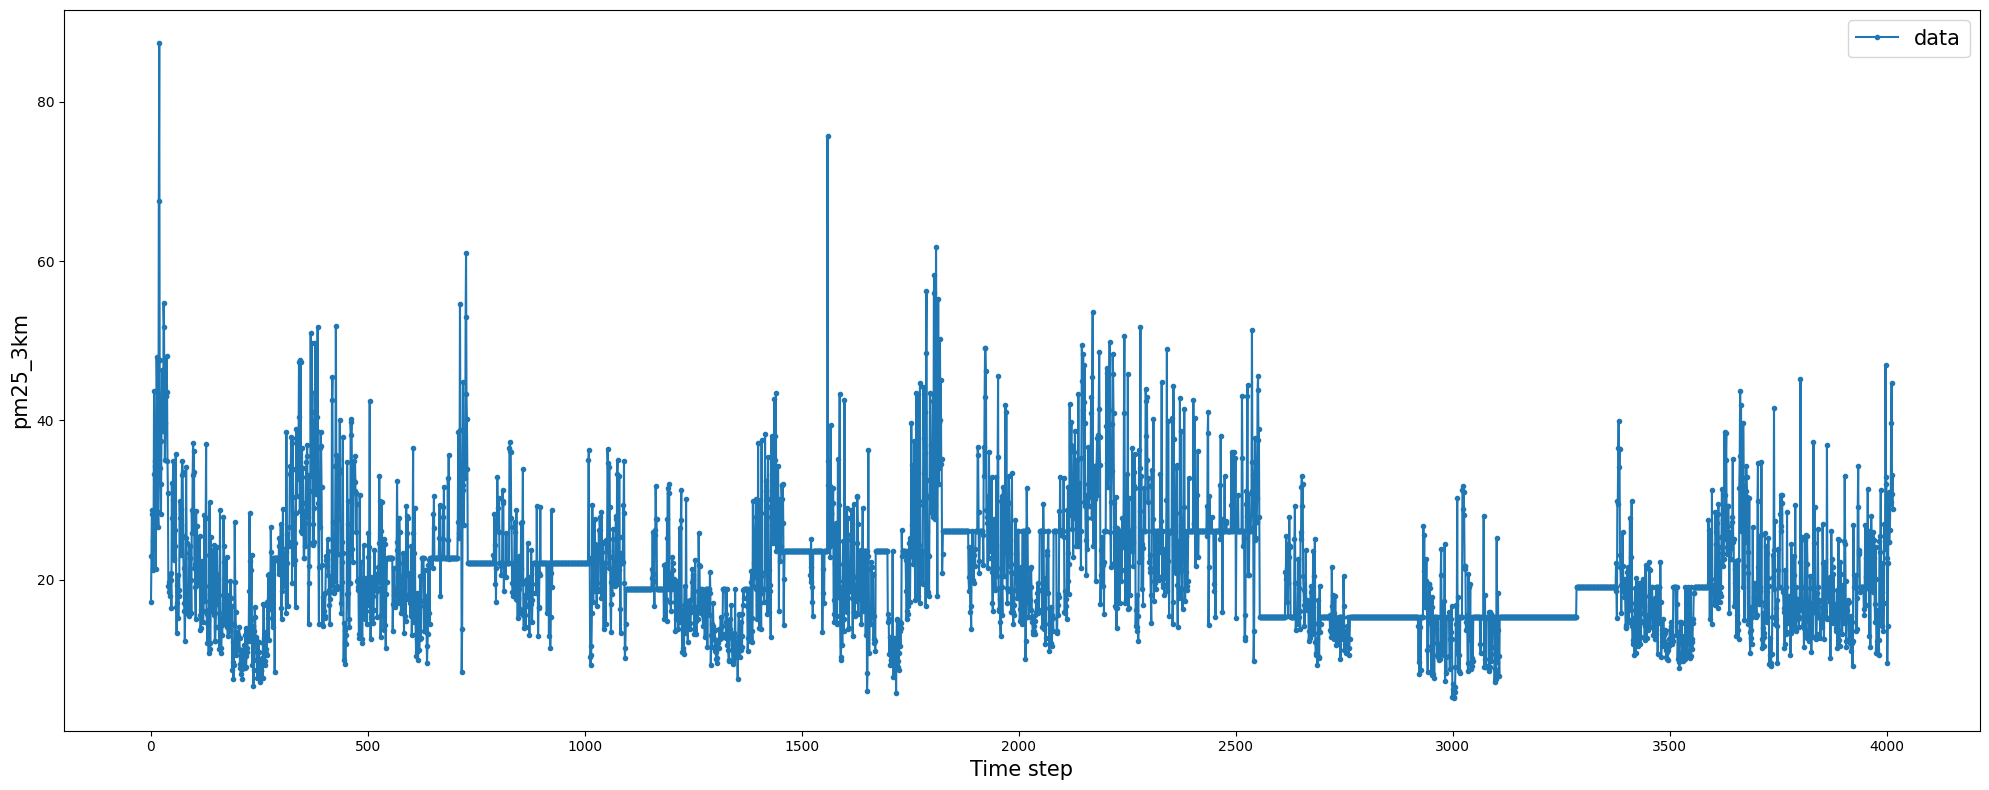

In [26]:
plot_1_data(data=y_mpair, datalabel="data", xlabel="Time step", ylabel="pm25_3km")

### Data normalization

In [27]:
mpair_features_scaler = MinMaxScaler()
X_mpair_scaled = mpair_features_scaler.fit_transform(X_mpair)
X_mpair_scaled = pd.DataFrame(X_mpair_scaled, columns=X_mpair.columns)
X_mpair_scaled

,lat,lon,pop,pm25_3km,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,wspd,station,tmp,rh,aod,hpbl
0,0.333333,0.375,0.915791,0.404852,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.548944,0.0,0.291319,0.276300,0.192266,0.344214
1,0.333333,0.375,0.915791,0.630145,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.303436,0.0,0.255205,0.277857,0.082887,0.347495
2,0.333333,0.375,0.915791,0.632451,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.188637,0.0,0.379682,0.309167,0.192266,0.303118
3,0.333333,0.375,0.915791,0.689589,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.136024,0.0,0.460990,0.306981,0.192266,0.406494
4,0.333333,0.375,0.915791,0.792440,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.382580,0.0,0.443089,0.320764,0.192266,0.448418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,0.333333,0.250,1.000000,0.351504,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.206324,1.0,0.144836,0.458418,0.194024,0.300308
4011,0.333333,0.250,1.000000,0.295950,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.274463,1.0,0.304301,0.304210,0.194024,0.443115
4012,0.333333,0.250,1.000000,0.266072,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.392243,1.0,0.304134,0.341219,0.042601,0.571233
4013,0.333333,0.250,1.000000,0.177692,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.622567,1.0,0.222773,0.275483,0.194024,0.459059


In [28]:
X_mpair_scaled.columns

Index(['lat', 'lon', 'pop', 'pm25_3km', 'road_den_1km', 'prim_road_len_1km',
       'near_dist', 'bareland', 'builtup', 'cropland', 'grassland',
       'treecover', 'water', 'ndvi', 'wspd', 'station', 'tmp', 'rh', 'aod',
       'hpbl'],
      dtype='object')

In [29]:
mpair_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_mpair_scaled = mpair_label_scaler.fit_transform(y_mpair)
y_mpair_scaled = pd.DataFrame(y_mpair_scaled, columns=y_mpair.columns)
y_mpair_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
4010,0.419453
4011,0.480472
4012,0.310835
4013,0.339606


## Dimensionality Reduction

Get the dimensionality reduction model from AOD data

### Data padding

In [30]:
padded_before = pd.DataFrame([X_mpair_scaled.iloc[0]] * conf["reduction"]["n_past"])
padded_after = pd.DataFrame([X_mpair_scaled.iloc[-1]] * (conf["reduction"]["n_future"] - 1))
X_mpair_scaled_padded = pd.concat([padded_before, X_mpair_scaled, padded_after], axis=0, ignore_index=True)

X_mpair_scaled_reframed, _ = reframePastFuture(X_mpair_scaled_padded, conf["reduction"]["n_past"], conf["reduction"]["n_future"])

print(X_mpair_scaled_reframed.shape)

NameError: name 'reframePastFuture' is not defined

### Evaluation board

In [31]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Encoder model paths

In [32]:
lstm_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_17_features_encoder.keras'
gru_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_grus2s_dim_reduction_16_features_encoder.keras'
cnnlstm_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_13_features_encoder.keras'

### Prediction + No dim reduction

In [33]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_lstm_prediction_no_dim_reduction",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

NameError: name 'predictLSTM' is not defined

In [ ]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["No"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

### Prediction + LSTM-Seq2Seq

In [ ]:
# Load encoder model
lstm_s2s_encoder_model = load_model(lstm_s2s_encoder_model_path)
lstm_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_19_features_encoder.keras'
lstm_s2s_encoder_model.summary()
lstm_s2s_output_n_features = lstm_s2s_encoder_model.layers[-1].output.shape[-1]

# Encode the data
X_mpair_scaled_lstm_s2s_encoded = lstm_s2s_encoder_model.predict(X_mpair_scaled_reframed)

# Printout
pd.DataFrame(X_mpair_scaled_lstm_s2s_encoded)

In [34]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled_lstm_s2s_encoded, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_lstm_prediction_with_lstms2s_dim_reduction_{lstm_s2s_output_n_features}_features",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

NameError: name 'predictLSTM' is not defined

In [ ]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [lstm_s2s_output_n_features]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

In [ ]:
pd.DataFrame(evaluation_board)

### Prediction + GRU-Seq2Seq

In [35]:
# Load encoder model
gru_s2s_encoder_model = load_model(gru_s2s_encoder_model_path)
gru_s2s_encoder_model.summary()
gru_s2s_output_n_features = gru_s2s_encoder_model.layers[-1].output.shape[-1]

# Encode the data
X_mpair_scaled_gru_s2s_encoded = gru_s2s_encoder_model.predict(X_mpair_scaled_reframed)

# Printout
pd.DataFrame(X_mpair_scaled_gru_s2s_encoded)

ValueError: File not found: filepath=/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_grus2s_dim_reduction_16_features_encoder.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled_gru_s2s_encoded, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_lstm_prediction_with_gru_dim_reduction_{gru_s2s_output_n_features}_features",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

In [ ]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [gru_s2s_output_n_features]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

In [ ]:
pd.DataFrame(evaluation_board)

### Prediction + CNNLSTM-Seq2Seq

In [ ]:
# Load encoder model
cnnlstm_s2s_encoder_model = load_model(cnnlstm_s2s_encoder_model_path)
cnnlstm_s2s_encoder_model.summary()
cnnlstm_s2s_output_n_features = cnnlstm_s2s_encoder_model.layers[-1].output.shape[-1]

# Encode the data
X_mpair_scaled_cnnlstm_s2s_encoded = cnnlstm_s2s_encoder_model.predict(X_mpair_scaled_reframed)

# Printout
pd.DataFrame(X_mpair_scaled_cnnlstm_s2s_encoded)

In [36]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled_cnnlstm_s2s_encoded, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_cnnlstm_prediction_with_lstms2s_dim_reduction_{cnnlstm_s2s_output_n_features}_features",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

NameError: name 'predictLSTM' is not defined

In [ ]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [cnnlstm_s2s_output_n_features]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

In [ ]:
pd.DataFrame(evaluation_board)